# Exploratory Data Analysis

## Key Takeaways

The data that we have collected to date is realtively barebones, including time series information of confirmed cases to date in each location. Using that information, we calculated the field incident cases, which may be more edifying than the cumulative total. 

We plan to gather more data about the regional demographics, possibly from US Census data. This would help us in further understanding how different demographic factors affect disease incidence. We would use the data to perform some sort of time series analysis to understand the patterns and possibly understand further spread in the future. We may use a 1D CNN or an RNN for this task, but plan to look into some existing models such as the ARIMA model.

Below, we have visualized a number of trends in the data that will help us to build our predictive model.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

import math as math

import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load and process data

In [2]:
## US Data ##

data = pd.read_csv("../data/covid_data.csv", dtype = str)

#Data types
data['date'] = pd.to_datetime(data['date'])
data['lat'] = pd.to_numeric(data['lat'])
data['long_'] = pd.to_numeric(data['long_'])
data['confirmed'] = pd.to_numeric(data['confirmed'])
data['deaths'] = pd.to_numeric(data['deaths'])

## Global Data ##
data_global = pd.read_csv("../data/covid_data_global.csv", dtype = str)

#Data types
data_global['date'] = pd.to_datetime(data_global['date'])
data_global['lat'] = pd.to_numeric(data_global['lat'])
data_global['long'] = pd.to_numeric(data_global['long'])
data_global['confirmed'] = pd.to_numeric(data_global['confirmed'])
data_global['deaths'] = pd.to_numeric(data_global['deaths'])


### Calculate Incident Cases

In [3]:
#US
data = data.sort_values(by = ['fips','date'])
data['prev_confirmed'] = data['confirmed'].shift(1) * \
    (data['fips'].fillna('') == \
     data['fips'].shift(1).fillna(''))
data['incident_cases'] = data.confirmed - data.prev_confirmed

#Global
data_global = data_global.sort_values(by = ['country_region','province_state','date'])
data_global['prev_confirmed'] = data_global['confirmed'].shift(1) * \
    (data_global['province_state'].fillna('') + data_global['country_region'].fillna('') == \
     data_global['province_state'].shift(1).fillna('') + data_global['country_region'].shift(1).fillna(''))
data_global['incident_cases'] = data_global.confirmed - data_global.prev_confirmed

#data_global.head(400)
#data.head(400)

### Preview the Data

In [4]:
data.head()

,uid,iso2,iso3,code3,fips,county,province_state,country_region,lat,long_,combined_key,confirmed,deaths,date,prev_confirmed,incident_cases
321,84010001,US,USA,840,10001.0,Kent,Delaware,US,39.086466,-75.568849,"Kent, Delaware, US",0,0,2020-01-22,NaN,NaN
3574,84010001,US,USA,840,10001.0,Kent,Delaware,US,39.086466,-75.568849,"Kent, Delaware, US",0,0,2020-01-23,0.0,0.0
6827,84010001,US,USA,840,10001.0,Kent,Delaware,US,39.086466,-75.568849,"Kent, Delaware, US",0,0,2020-01-24,0.0,0.0
10080,84010001,US,USA,840,10001.0,Kent,Delaware,US,39.086466,-75.568849,"Kent, Delaware, US",0,0,2020-01-25,0.0,0.0
13333,84010001,US,USA,840,10001.0,Kent,Delaware,US,39.086466,-75.568849,"Kent, Delaware, US",0,0,2020-01-26,0.0,0.0


## Time Trends

/Users/genevievelyons/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


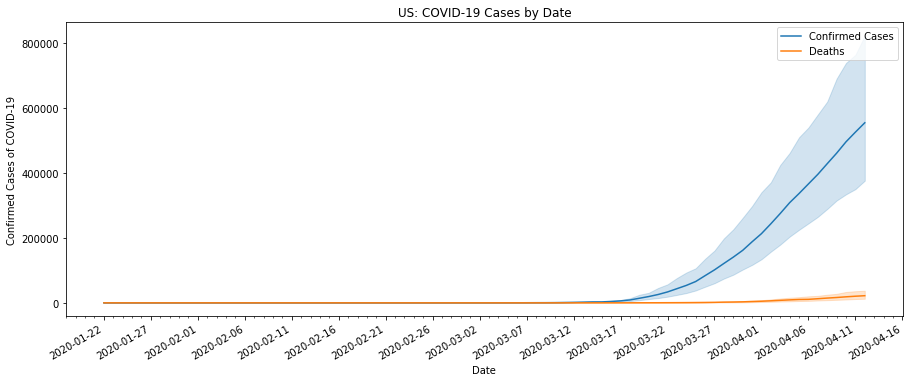

In [5]:
fig, ax = plt.subplots(figsize = (15,6))
sns.lineplot(x = data.date, y = data.confirmed, estimator = 'sum', label = 'Confirmed Cases')
sns.lineplot(x = data.date, y = data.deaths, estimator = 'sum', label = 'Deaths')
#sns.lineplot(x = data.date, y = data.incident_cases, estimator = 'sum', label = 'Incident Cases')
#Labels
plt.title("US: COVID-19 Cases by Date")
plt.xlabel("Date")
plt.ylabel("Confirmed Cases of COVID-19")
#Format x-axis
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

plt.show();

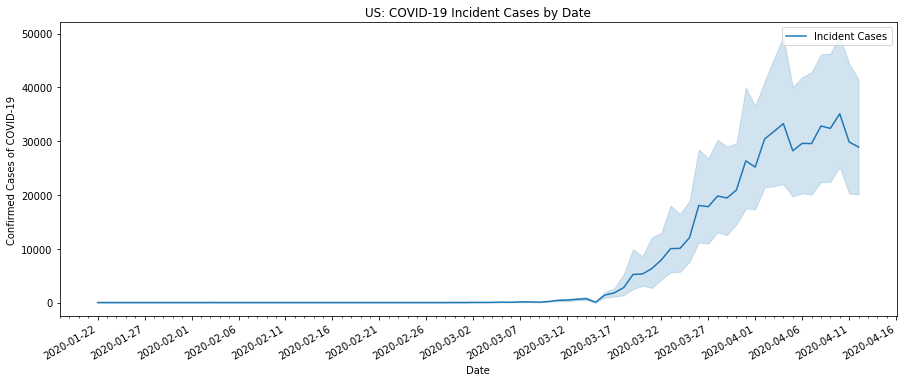

In [6]:
fig, ax = plt.subplots(figsize = (15,6))
# sns.lineplot(x = data.date, y = data.confirmed, estimator = 'sum', label = 'Confirmed Cases')
# sns.lineplot(x = data.date, y = data.deaths, estimator = 'sum', label = 'Deaths')
sns.lineplot(x = data.date, y = data.incident_cases, estimator = 'sum', label = 'Incident Cases')
#Labels
plt.title("US: COVID-19 Incident Cases by Date")
plt.xlabel("Date")
plt.ylabel("Confirmed Cases of COVID-19")
#Format x-axis
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()
plt.show();

**We can see that the US currently has almost 600k cases and is on the rise. We will likely get more information on trends by looking at specific locations that have been disproportionately affected.**

## State Trends

### New York City Trends

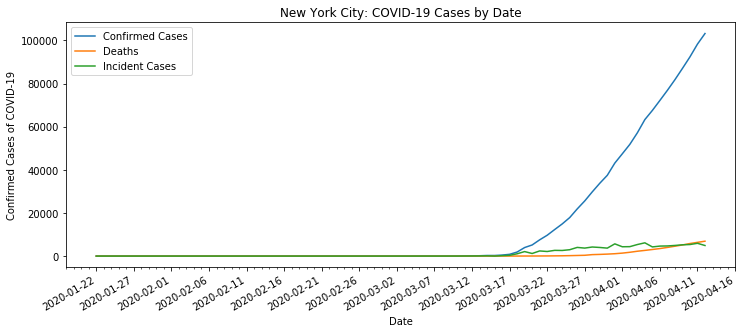

In [7]:
nyc = data[(data.province_state == 'New York') & (data.county == 'New York')]

fig, ax = plt.subplots(figsize = (12,5))
sns.lineplot(x = nyc.date, y = nyc.confirmed, estimator = 'sum', label = 'Confirmed Cases')
sns.lineplot(x = nyc.date, y = nyc.deaths, estimator = 'sum', label = 'Deaths')
sns.lineplot(x = nyc.date, y = nyc.incident_cases, estimator = 'sum', label = 'Incident Cases')
#Labels
plt.title("New York City: COVID-19 Cases by Date")
plt.xlabel("Date")
plt.ylabel("Confirmed Cases of COVID-19")
#Format x-axis
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()
plt.show();

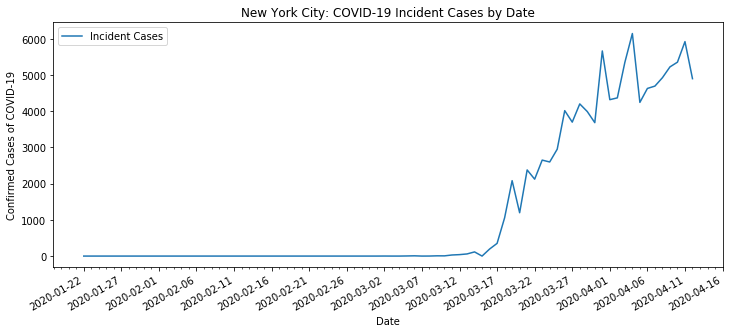

In [8]:
fig, ax = plt.subplots(figsize = (12,5))
# sns.lineplot(x = nyc.date, y = nyc.confirmed, estimator = 'sum', label = 'Confirmed Cases')
# sns.lineplot(x = nyc.date, y = nyc.deaths, estimator = 'sum', label = 'Deaths')
sns.lineplot(x = nyc.date, y = nyc.incident_cases, estimator = 'sum', label = 'Incident Cases')
#Labels
plt.title("New York City: COVID-19 Incident Cases by Date")
plt.xlabel("Date")
plt.ylabel("Confirmed Cases of COVID-19")
#Format x-axis
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()
plt.show();

**As we know, New York City saw a massive rise in incident cases in mid to late March. The trend continues to spike eratically, although generally speaking we are seeing about 5k new cases per day. This may make NYC a good exemplar for the trends of the virus as it is introduced into a given community.**

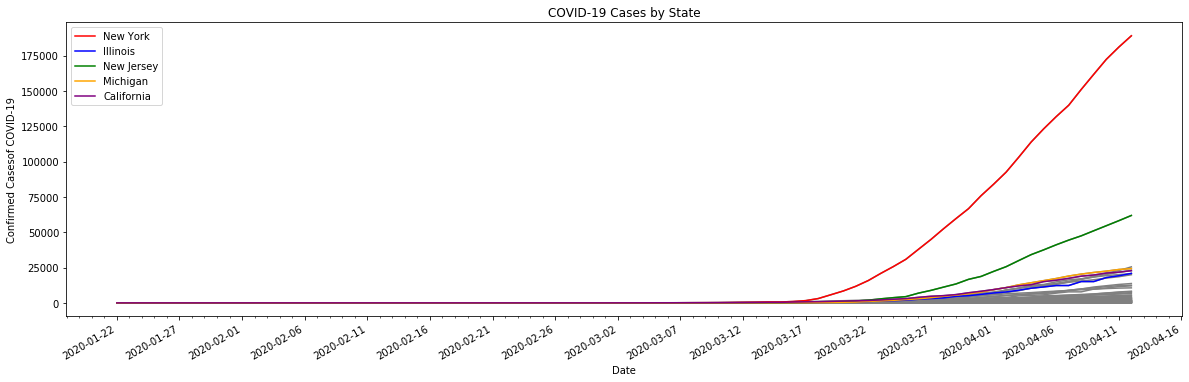

In [9]:

fig, ax = plt.subplots(figsize = (20,6))
#All states
for st in np.unique(data.province_state):
    sns.lineplot(x = data[data.province_state == st].date, y = data[data.province_state == st].confirmed, \
                 estimator = 'sum', err_style = None, color = "gray")
#Outlier states
for st, c in zip(["New York","Illinois","New Jersey","Michigan", "California"], \
                 ["red", "blue", "green", "orange", "purple"]):
    sns.lineplot(x = data[data.province_state == st].date, y = data[data.province_state == st].confirmed, \
                 label = st, estimator = 'sum', err_style = None, color = c)
#Labels
plt.title("COVID-19 Cases by State")
plt.xlabel("Date")
plt.ylabel("Confirmed Casesof COVID-19")
#Format x-axis
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()
plt.show();


**There are a few clear outliers when looking at the trends by state: New York, New Jersey, Illinois, Michigan, and California. All but Michigan were anticipated due to population density around large cities in those states.**

In [10]:
data[data.date == '2020-04-02'].groupby(data.province_state).confirmed.sum().sort_values(ascending = False).head(10)

province_state
New York         92506
New Jersey       25590
Michigan         10791
California       10773
Louisiana         9149
Florida           9008
Massachusetts     8966
Illinois          7695
Pennsylvania      7268
Washington        6389
Name: confirmed, dtype: int64

In [11]:
data[data.date == '2020-04-02'].sort_values(by = ['confirmed'], axis = 0, ascending = False).head()


,uid,iso2,iso3,code3,fips,county,province_state,country_region,lat,long_,combined_key,confirmed,deaths,date,prev_confirmed,incident_cases
232826,84036061,US,USA,840,36061.0,New York,New York,US,40.767273,-73.971526,"New York City, New York, US",51809,1762,2020-04-02,47439.0,4370.0
232855,84036119,US,USA,840,36119.0,Westchester,New York,US,41.162784,-73.757417,"Westchester, New York, US",11567,64,2020-04-02,10683.0,884.0
232825,84036059,US,USA,840,36059.0,Nassau,New York,US,40.740665,-73.589419,"Nassau, New York, US",10587,76,2020-04-02,9554.0,1033.0
232847,84036103,US,USA,840,36103.0,Suffolk,New York,US,40.883201,-72.801217,"Suffolk, New York, US",8746,69,2020-04-02,7605.0,1141.0
231578,84017031,US,USA,840,17031.0,Cook,Illinois,US,41.841448,-87.816588,"Cook, Illinois, US",5575,107,2020-04-02,5152.0,423.0


## Global Trends

### Italy

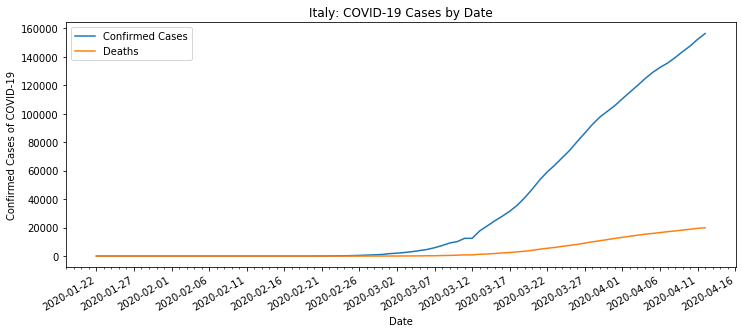

In [12]:
italy = data_global[data_global.country_region == 'Italy']

fig, ax = plt.subplots(figsize = (12,5))
sns.lineplot(x = italy.date, y = italy.confirmed, estimator = 'sum', label = 'Confirmed Cases')
sns.lineplot(x = italy.date, y = italy.deaths, estimator = 'sum', label = 'Deaths')
#sns.lineplot(x = italy.date, y = italy.incident_cases, estimator = 'sum', label = 'Incident Cases')
#Labels
plt.title("Italy: COVID-19 Cases by Date")
plt.xlabel("Date")
plt.ylabel("Confirmed Cases of COVID-19")
#Format x-axis
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()
plt.show();

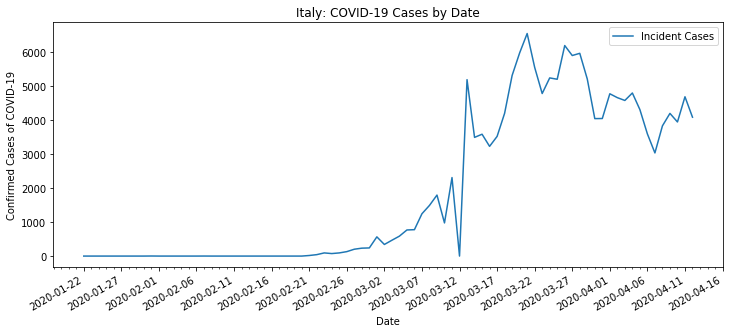

In [13]:
fig, ax = plt.subplots(figsize = (12,5))
# sns.lineplot(x = italy.date, y = italy.confirmed, estimator = 'sum', label = 'Confirmed Cases')
# sns.lineplot(x = italy.date, y = italy.deaths, estimator = 'sum', label = 'Deaths')
sns.lineplot(x = italy.date, y = italy.incident_cases, estimator = 'sum', label = 'Incident Cases')
#Labels
plt.title("Italy: COVID-19 Cases by Date")
plt.xlabel("Date")
plt.ylabel("Confirmed Cases of COVID-19")
#Format x-axis
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()
plt.show();

**The trends for Italy show that the virus is slowing its spread as the incident cases flatten out and may even be decreasing.**

### China

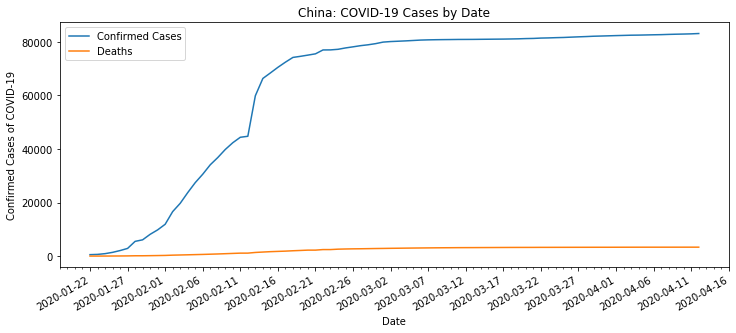

In [14]:
china = data_global[data_global.country_region == 'China']

fig, ax = plt.subplots(figsize = (12,5))
sns.lineplot(x = china.date, y = china.confirmed, estimator = 'sum', err_style = None, label = 'Confirmed Cases')
sns.lineplot(x = china.date, y = china.deaths, estimator = 'sum', err_style = None, label = 'Deaths')
#sns.lineplot(x = china.date, y = china.incident_cases, estimator = 'sum', err_style = None, label = 'Incident Cases')
#Labels
plt.title("China: COVID-19 Cases by Date")
plt.xlabel("Date")
plt.ylabel("Confirmed Cases of COVID-19")
#Format x-axis
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()
plt.show();

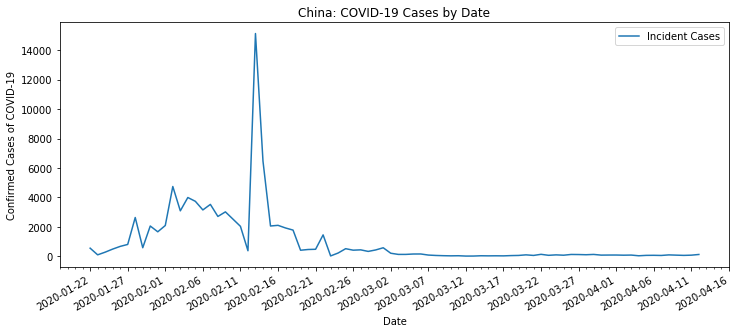

In [15]:

fig, ax = plt.subplots(figsize = (12,5))
# sns.lineplot(x = china.date, y = china.confirmed, estimator = 'sum', err_style = None, label = 'Confirmed Cases')
# sns.lineplot(x = china.date, y = china.deaths, estimator = 'sum', err_style = None, label = 'Deaths')
sns.lineplot(x = china.date, y = china.incident_cases, estimator = 'sum', err_style = None, label = 'Incident Cases')
#Labels
plt.title("China: COVID-19 Cases by Date")
plt.xlabel("Date")
plt.ylabel("Confirmed Cases of COVID-19")
#Format x-axis
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()
plt.show();

**The virus seems to have tapered off in China. There was a very large spike in cases in mid-February, which will be important to keep on eye on as it may be a reporting error (e.g., the reporting may have been lagged); either way, it is an outlier that may end up disporportionately affecting our model.**

## Geographic Trends

### USA

In [19]:
#Remove territories for mapping purposes
non_states = ['American Samoa','Diamond Princess', 'Grand Princess','Guam','Northern Mariana Islands', 'Puerto Rico'\
             , 'Virgin Islands']
data = data[~data['province_state'].isin(non_states)]

#Groupby to get daily totals
daily_total = data.groupby(['date','province_state'], as_index = False).sum()

#Load in shapefile of the US states
#from https://alicia.data.socrata.com/Government/States-21basic/jhnu-yfrj
usa = gpd.read_file('../data/States_21basic/geo_export_d7c791c0-6990-477e-9d1c-462fd3ff41b3.shp')
shape_data = usa.merge(daily_total, left_on = 'state_name', right_on = 'province_state')

In [20]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

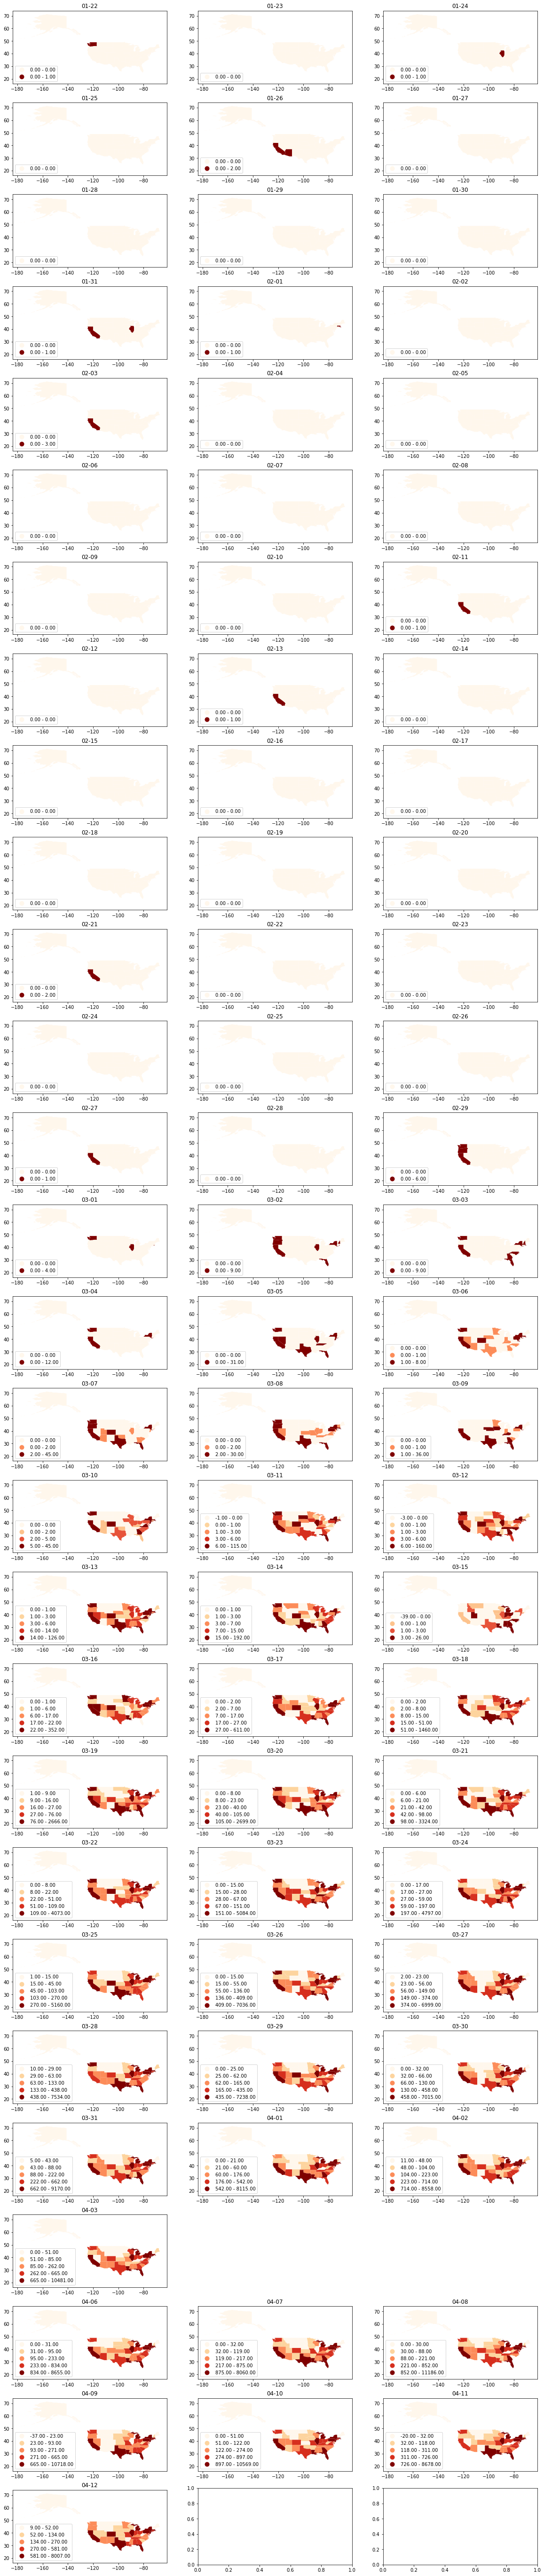

In [22]:
#to be able to use scheme = "quantiles"
#use - conda install -c conda-forge mapclassify

#getting the number of days as this will change with our
#daily updating data

num_days = len(shape_data.date.unique())

fig, axs = plt.subplots(math.ceil(num_days/3), 3, figsize = (20,100))

#Delete excess plots depending on how many days we are looking at
if np.mod(num_days, 3) == 2:
    fig.delaxes(axs[24][2])
elif np.mod(num_days, 3) == 1:
    fig.delaxes(axs[24][2])
    fig.delaxes(axs[24][1])


num= 0
num2= 0
for i in shape_data.date.unique():
    shape_data[shape_data.date == i].plot(column = 'incident_cases', cmap='OrRd',\
                                          legend = True,
                                          ax=axs[num][num2],
                                          scheme="quantiles",
                                        legend_kwds={'loc': 'lower left'})
    axs[num][num2].set_title(i.astype('str')[5:10])
    
    num2+=1
    
    #go to the next row
    if num2 == 3:
        num2 =0
        num+=1

**These maps by quantile give us the perspective of categorizing states based on their number of incident cases relative to others. We can see the cases first focusing on the coasts with New York and California and then spreading across the country towards the midwest.**

### China

In [23]:
china_shapes = gpd.read_file('../data/chn_admbnda_adm1_ocha/chn_admbnda_adm1_ocha.shp')

#formatting to ensure that the province names are the same
china_shapes['ADM1_EN'] = china_shapes['ADM1_EN'].str.split(' ').str[0]

china['province_state'] = china['province_state'].str.split(' ').str[0]
china.province_state = china.province_state.replace('Macau', 'Macao')
china_shapes.drop(china_shapes[china_shapes.ADM1_EN == 'Taiwan'].index, inplace=True)

#same methodology as with the US - groupby to get daily totals
daily_china_total = china.groupby(['date','province_state'], as_index = False).sum()

#merge in the geospatial data on province name
china_shape_data = china_shapes.merge(daily_china_total, left_on = 'ADM1_EN', right_on = 'province_state')

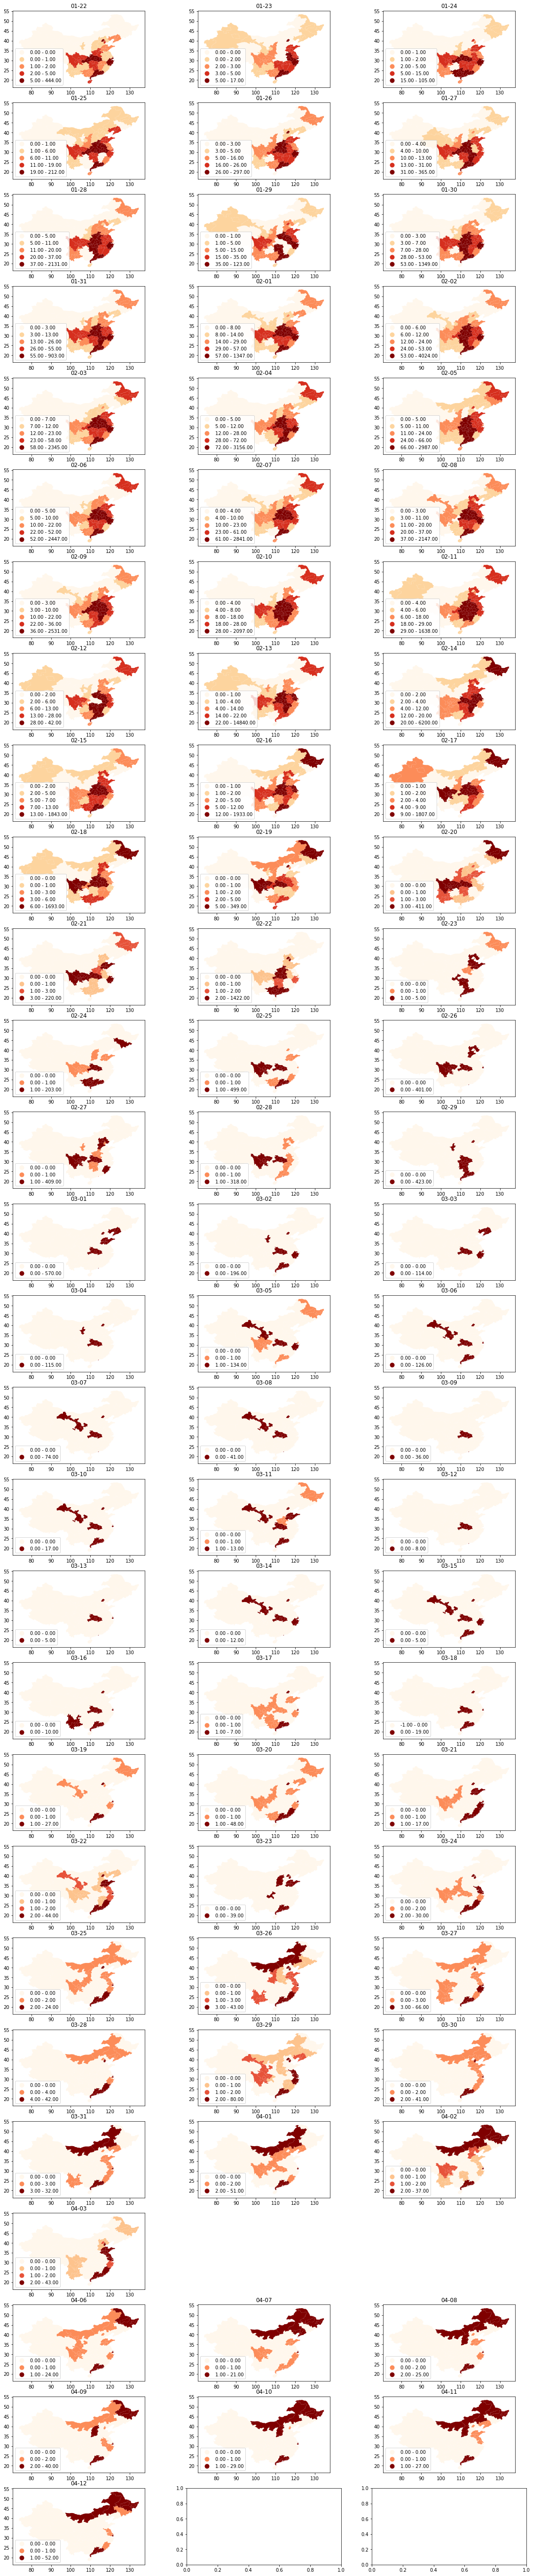

In [24]:
#to be able to use scheme = "quantiles"
#use - conda install -c conda-forge mapclassify

#getting the number of days as this will change with our
#daily updating data

num_days = len(china_shape_data.date.unique())

fig, axs = plt.subplots(math.ceil(num_days/3), 3, figsize = (20,100))

#Delete excess plots depending on how many days we are looking at
if np.mod(num_days, 3) == 2:
    fig.delaxes(axs[24][2])
elif np.mod(num_days, 3) == 1:
    fig.delaxes(axs[24][2])
    fig.delaxes(axs[24][1])


num= 0
num2= 0
for i in china_shape_data.date.unique():
    china_shape_data[china_shape_data.date == i].plot(column = 'incident_cases', cmap='OrRd',\
                                          legend = True,
                                          ax=axs[num][num2],
                                          scheme="quantiles",
                                        legend_kwds={'loc': 'lower left'})
    axs[num][num2].set_title(i.astype('str')[5:10])
    
    num2+=1
    
    #go to the next row
    if num2 == 3:
        num2 =0
        num+=1

**The maps of China show a clear spread of the virus from. Wuhan to the surrounding provinces.**